<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Convolutional Neural Network (CNN)

In [42]:
!pip install scikeras
!pip install bayesian-optimization

###Load Libraries

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define Functions to Facilitate Metrics Evaluation

In [80]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [81]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/multivariate-time-series-prediction-of-crude-palm-oil-price-data-science-approach/main/cleaned_data/preprocessed.csv'
df = read_csv(path, index_col=0)
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
0,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
1,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
3,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
4,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [82]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')
del df['Date']

In [83]:
df.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Plot the Target Variable

Text(0.5, 0, 'Date')

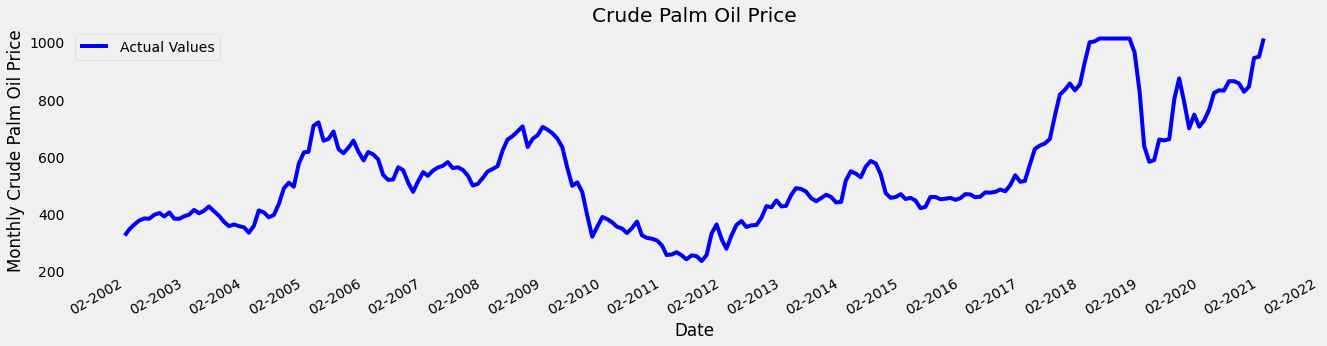

In [84]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df.index, df['cpo_pri'], color = 'blue',  label = 'Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['Actual Values', 'Crude Palm Oil Price 2002-2021'],loc='best')
plt.title('Crude Palm Oil Price')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')

###Visualize Multiple Time Series

In [85]:
fig = make_subplots(rows=6, cols=1)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cpo_pri'],name='crude palm oil price'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cno_pri'],name='coconut oil price'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['rps_pri'],name='rapeseed oil price'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['pno_pri'],name='peanut oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['sbo_pri'],name='soybean oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['wti_spri'],name='west texas intermediate spot price'),
    row=4, col=1

)
fig.update_layout(height=1000, width=1200, title_text="Time Series")
fig.show()

<Figure size 1800x720 with 0 Axes>

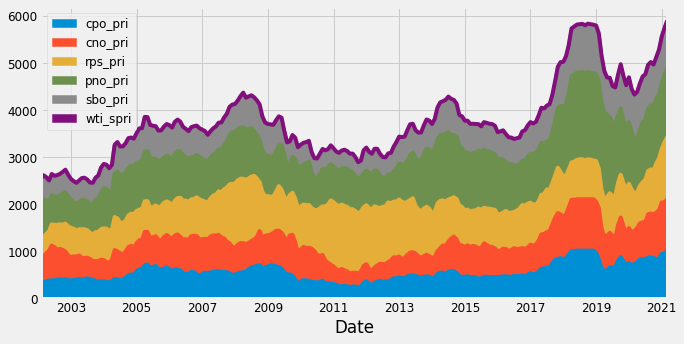

In [86]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('Date');
ax.legend(fontsize=12);

##**Convolutional Neural Network Forecasting Technique (CNN)**

###**Split Data into Train Test Segments**

In [87]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 184
Test size: 46


###Plot Train Test Data

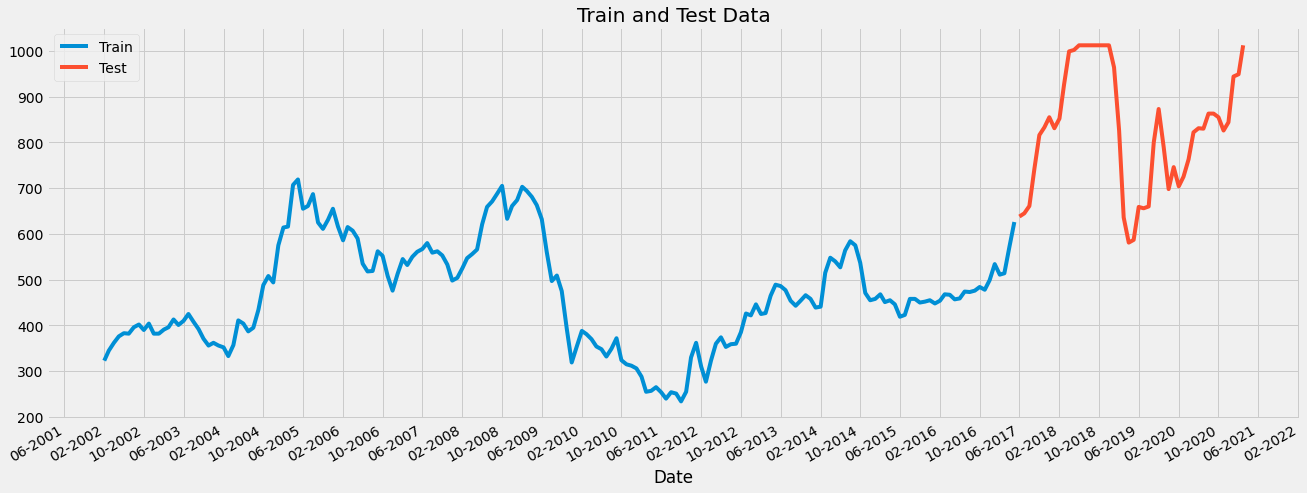

In [88]:
#Plotting data
plt.figure(figsize=(20,8))
plt.title("Train and Test Data")
plt.plot(train.index, train['cpo_pri'], label='Train')
plt.plot(test.index, test['cpo_pri'], label='Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=8))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [89]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

184 46


In [90]:
print(train.shape)
train.head()

(184, 6)


,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Rescaling Traininh Data

In [91]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,0.288625,0.013238,0.323766,0.432130,0.109026
2002-03-01,345.0,0.443124,0.005303,0.272101,0.472692,0.044200
2002-04-01,362.0,0.526316,0.000000,0.179104,0.427358,0.006514
2002-05-01,376.0,0.595925,0.004228,0.059701,0.370094,0.000000
2002-06-01,383.0,0.769100,0.042041,0.065442,0.339076,0.010236


In [92]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

Date
2002-02-01    0.183505
2002-03-01    0.228866
2002-04-01    0.263918
2002-05-01    0.292784
2002-06-01    0.307216
Name: cpo_pri, dtype: float64

In [93]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2017-06-01,638.0,0.757216,0.455910,0.585121,0.979313,0.431141
2017-07-01,645.0,0.811545,0.517005,0.521619,1.021570,0.442463
2017-08-01,661.0,0.821732,0.485027,0.566257,1.031090,0.384150
2017-09-01,743.0,0.921902,0.482428,0.592618,1.113813,0.403381
2017-10-01,816.0,1.033956,0.507880,0.697371,1.197323,0.345068


In [94]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

Date
2017-06-01    0.832990
2017-07-01    0.847423
2017-08-01    0.880412
2017-09-01    1.049485
2017-10-01    1.200000
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [95]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(181, 3, 6) (181,)


In [ ]:
#test_lag = test[1:23]
#len(test) - 1

In [ ]:
#decrement naturally.
#shifted = test.set_index(["Date"]).unstack().shift(3).stack()

###Create Model

In [96]:
cnn_model1 = tf.keras.Sequential()
cnn_model1.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_test.shape[1], X_test.shape[2])))
cnn_model1.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model1.add(tf.keras.layers.Flatten())
cnn_model1.add(tf.keras.layers.Dense(50, activation='relu'))
cnn_model1.add(tf.keras.layers.Dense(1))
cnn_model1.compile(loss='mse', optimizer='adam')
cnn_model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 2, 64)             832       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 50)                3250      
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 4,133
Trainable params: 4,133
Non-trainable params: 0
____________________________________________________

In [ ]:
'''
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=1, activation='relu', input_shape=(X_test.shape[1], X_test.shape[2]))) #64,32, 16, 8 (best so far)
cnn_model.add(Dropout(0.1))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=1))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(4, activation='relu')) #32, 8,4
#cnn_model.add(Dropout(0.1))
cnn_model.add(tf.keras.layers.Dense(1))
#cnn_model.add(Dropout(0.25))
#Dropout(droprate)
cnn_model.compile(loss='mse', optimizer='adam')
cnn_model.summary()
'''

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 3, 8)              56        
                                                                 
 dropout_1 (Dropout)         (None, 3, 8)              0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 3, 8)             0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 24)                0         
                                                                 
 dense_6 (Dense)             (None, 4)                 100       
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                      

In [97]:
cnn_history = cnn_model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
6/6 [==============================] - 1s 32ms/step - loss: 0.3608 - val_loss: 1.1933
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 0.1302 - val_loss: 0.3827
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0368 - val_loss: 0.0853
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0363 - val_loss: 0.0608
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0301 - val_loss: 0.0758
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0188 - val_loss: 0.1241
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0177 - val_loss: 0.1320
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0160 - val_loss: 0.0964
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0130 - val_loss: 0.0686
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0120 - val_loss: 0.0612
Epoch 11/50
6/6 [=====================

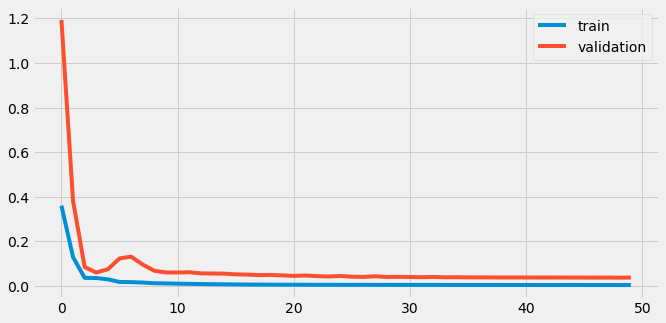

In [98]:
plt.plot(cnn_history.history['loss'], label='train')
plt.plot(cnn_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

From the above graph we can see that the CNN neural network show that the validation error is higher than the train error. This mean that there is room for improvement.


In [ ]:
#score = cnn_model1.evaluate(X_test, y_test, verbose=0)
#score

0.03230196610093117

Test Loss# = 0.0443 

###Applying Grid Search

In [ ]:
def algorithm_pipeline(X_train, X_test, y_train, y_test, 
                       model, param_grid, cv=5, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train, y_train)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test)
    else:
      pred = fitted_model.predict(X_test)
    
    return fitted_model, pred

In [ ]:
# Readying neural network model
def build_cnn(activation = 'relu',dropout_rate = 0.2, optimizer = 'Adam', learning_rate=0.01):
    cnn_model = tf.keras.Sequential()
    cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_test.shape[1], X_test.shape[2])))
    cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(50, activation='relu'))
    cnn_model.add(tf.keras.layers.Dense(1))
  
    
    #cnn_model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    cnn_model.compile(loss='mse', optimizer= optimizer, metrics=['accuracy'])

    #optimizer=SGD(lr, momentum)
    
    return cnn_model

In [ ]:
param_grid = {
              'epochs':[50,100],
              'batch_size':[32,64,128],
              'learning_rate' : [0.001,0.005,0.01],
              #'batch_size' :          [32, 128],
              'optimizer' :           ['Adam', 'Nadam'],
              'dropout_rate' :        [0.1, 0.2,0.3],
              'activation' :          ['relu', 'elu']
             }

#model = KerasClassifier(build_fn = build_cnn, verbose=0)
estimator = KerasRegressor(build_fn=build_cnn, nb_epoch=50, batch_size=32, verbose=False)

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, n_jobs = -1)
grid.fit(X_train, y_train)
print(grid.best_params_)

#model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, estimator, param_grid, cv=5, scoring_fit='neg_log_loss')

{'activation': 'elu', 'batch_size': 128, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'Nadam'}


**Best:**

* 'activation': 'elu'
*  'batch_size': 128,
*  'dropout_rate': 0.2
*  'epochs': 100
*  'learning_rate': 0.01
*  'optimizer': 'Nadam'

In [ ]:
y_pred = grid.predict(X_test)

In [ ]:
print (np.c_[y_test, y_pred])

[[1.04948454 0.86159205]
 [1.2        0.94477218]
 [1.23505155 1.06482434]
 [1.28041237 1.12181592]
 [1.23092784 1.17735183]
 [1.2742268  1.20528138]
 [1.42680412 1.2453506 ]
 [1.57731959 1.35532594]
 [1.58350515 1.4493804 ]
 [1.60463918 1.46042609]
 [1.60463918 1.48477113]
 [1.60463918 1.48948407]
 [1.60463918 1.48867047]
 [1.60463918 1.4925859 ]
 [1.60463918 1.49229717]
 [1.60463918 1.48561716]
 [1.50515464 1.47988677]
 [1.22061856 1.44997263]
 [0.82886598 1.34265041]
 [0.71546392 1.17455292]
 [0.72783505 0.89694405]
 [0.87628866 0.72843957]
 [0.87010309 0.74267769]
 [0.87835052 0.86789656]
 [1.16701031 0.86966419]
 [1.31752577 0.9798978 ]
 [1.1443299  1.22367263]
 [0.95670103 1.24745798]
 [1.0556701  1.15099692]
 [0.96907216 1.06236517]
 [1.01237113 1.07604849]
 [1.09072165 1.049196  ]
 [1.21237113 1.08059812]
 [1.23092784 1.16246367]
 [1.22886598 1.19604826]
 [1.29690722 1.20439827]
 [1.29690722 1.20233703]
 [1.28041237 1.1604073 ]
 [1.22061856 1.16790533]
 [1.25773196 1.19073558]


In [ ]:
=]''''
from sklearn.model_selection import RandomizedSearchCV

def search_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False, search_mode = 'GridSearchCV', n_iterations = 0):
    fitted_model = None
    
    if(search_mode == 'GridSearchCV'):
        gs = GridSearchCV(
            estimator=model,
            param_grid=param_grid, 
            cv=cv, 
            n_jobs=-1, 
            scoring=scoring_fit,
            verbose=2
        )
        fitted_model = gs.fit(X_train_data, y_train_data)

    elif (search_mode == 'RandomizedSearchCV'):
        rs = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid, 
            cv=cv,
            n_iter=n_iterations,
            n_jobs=-1, 
            scoring=scoring_fit,
            verbose=2
        )
        fitted_model = rs.fit(X_train_data, y_train_data)
    
    
    if(fitted_model != None):
        if do_probabilities:
            pred = fitted_model.predict_proba(X_test_data)
        else:
            pred = fitted_model.predict(X_test_data)
            
        return fitted_model, pred
'''

In [ ]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370. 354. 348.
  332. 349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254.
  251. 234. 255. 330. 362. 310. 277. 323. 360. 374. 353. 359. 360. 385.
  426. 422. 446. 425. 427. 465. 489. 486. 477. 454. 443. 454. 466. 458.
  439. 441. 515. 548. 540. 527. 564. 584. 575. 537. 471. 455. 458. 468.
  451. 455. 446. 419. 423. 458. 458. 450. 452. 455. 448. 454. 468. 467.
  457. 459. 474. 473. 476. 484. 478. 499. 534. 511. 514. 572. 626.]]
[[ 743.    816.    833.    855.    831.    852.    926.    999.   1

In [ ]:
y_train_inv = y_train_inv.flatten()
y_train_inv
y_test_inv = y_test_inv.flatten()
y_test_inv

array([ 743.  ,  816.  ,  833.  ,  855.  ,  831.  ,  852.  ,  926.  ,
        999.  , 1002.  , 1012.25, 1012.25, 1012.25, 1012.25, 1012.25,
       1012.25, 1012.25,  964.  ,  826.  ,  636.  ,  581.  ,  587.  ,
        659.  ,  656.  ,  660.  ,  800.  ,  873.  ,  789.  ,  698.  ,
        746.  ,  704.  ,  725.  ,  763.  ,  822.  ,  831.  ,  830.  ,
        863.  ,  863.  ,  855.  ,  826.  ,  844.  ,  944.  ,  949.  ,
       1012.25])

In [ ]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([651.87213, 692.21454, 750.4398 , 778.0807 , 805.0156 , 818.56146,
       837.99506, 891.33307, 936.94946, 942.30664, 954.114  , 956.3998 ,
       956.0052 , 957.9042 , 957.7641 , 954.5243 , 951.74506, 937.2367 ,
       885.1854 , 803.65814, 669.0179 , 587.29315, 594.19867, 654.9298 ,
       655.7871 , 709.2504 , 827.4812 , 839.0171 , 792.2335 , 749.2471 ,
       755.8835 , 742.86005, 758.0901 , 797.79486, 814.0834 , 818.1332 ,
       817.1334 , 796.79755, 800.4341 , 811.5068 , 810.3965 , 874.69116,
       896.017  ], dtype=float32)

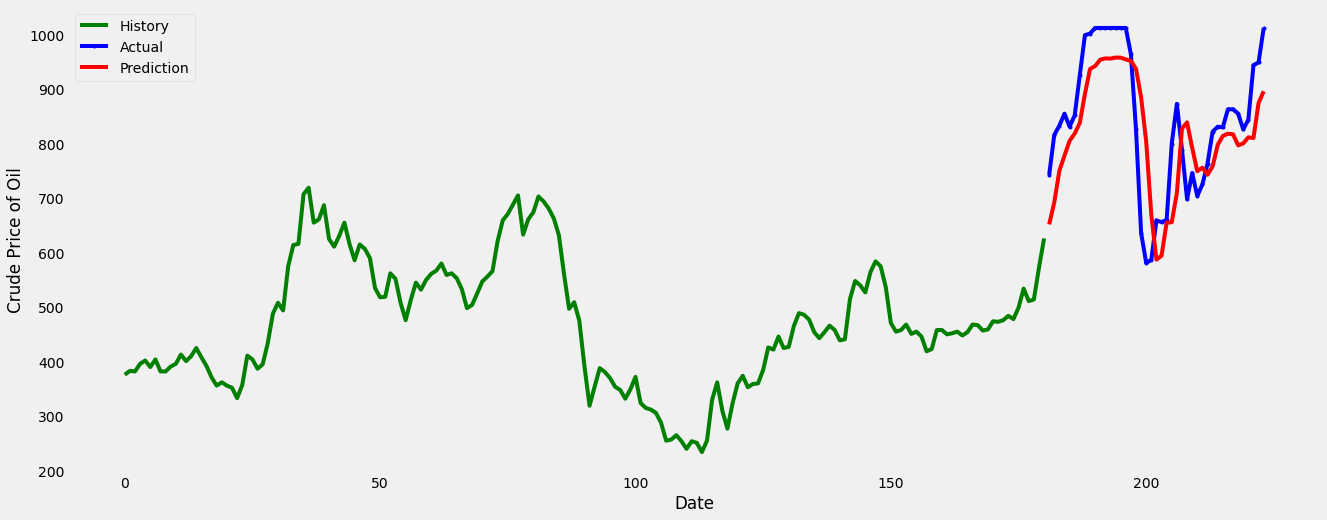

In [ ]:
plt.figure(figsize=(20,8))
plt.grid()
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Date')
plt.legend()
plt.show();

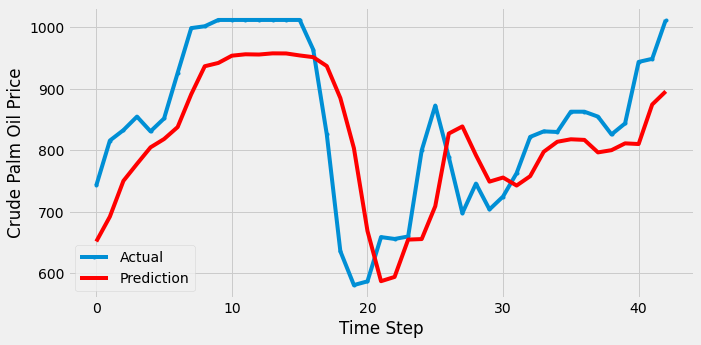

In [ ]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
MAE_cnn = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the CNN Model is:', MAE_cnn)

MDA_cnn = mda(y_test_inv, y_pred_inv)
print('MDA value of the CNN Model is:', MDA_cnn)

MAPE_cnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the CNN Model is:', MAPE_cnn)

RMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the CNN Model is:', RMSE_cnn)

MSE_cnn = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the CNN Model is:', MSE_cnn)

EVS_cnn = explained_variance_score(y_test_inv, y_pred_inv)
print('EVS score of the CNN Model is:', EVS_cnn)

MAE value of the CNN Model is: 74.21716734420421
MDA value of the CNN Model is: 0.5714285714285714
MAPE value of the CNN Model is: 9.312571243247941
RMSE value of the CNN Model is: 90.41206195943381
MSE value of the CNN Model is: 8174.3409477565
EVS score of the CNN Model is: 0.5440791630392536


###Applying Random Search

In [ ]:
param_grid = {
              'epochs':[50,100],
              'batch_size':[32,64,128],
              'learning_rate' : [0.001,0.005,0.01],
              #'batch_size' :          [32, 128],
              'optimizer' :           ['Adam', 'Nadam'],
              'dropout_rate' :        [0.1, 0.2,0.3],
              'activation' :          ['relu', 'elu']
             }

#model = KerasClassifier(build_fn = build_cnn, verbose=0)
estimator = KerasRegressor(build_fn=build_cnn, nb_epoch=50, batch_size=32, verbose=False)

grid = RandomizedSearchCV(estimator=estimator, param_distributions = param_grid, cv=5, n_jobs = -1)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'optimizer': 'Adam', 'learning_rate': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'batch_size': 128, 'activation': 'elu'}


{'optimizer': 'Adam', 'learning_rate': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'batch_size': 128, 'activation': 'elu'}

In [ ]:
y_predRS = grid.predict(X_test)

In [ ]:
print (np.c_[y_test, y_predRS])

[[1.04948454 0.87229049]
 [1.2        0.96109253]
 [1.23505155 1.06502402]
 [1.28041237 1.11877692]
 [1.23092784 1.16853166]
 [1.2742268  1.176543  ]
 [1.42680412 1.1912024 ]
 [1.57731959 1.30072582]
 [1.58350515 1.35369945]
 [1.60463918 1.37953091]
 [1.60463918 1.36094522]
 [1.60463918 1.36587334]
 [1.60463918 1.36038208]
 [1.60463918 1.36372578]
 [1.60463918 1.3742379 ]
 [1.60463918 1.36708355]
 [1.50515464 1.35925722]
 [1.22061856 1.35082388]
 [0.82886598 1.30456185]
 [0.71546392 1.14752162]
 [0.72783505 0.95566833]
 [0.87628866 0.8626259 ]
 [0.87010309 0.83861244]
 [0.87835052 0.87617248]
 [1.16701031 0.87132436]
 [1.31752577 0.98279142]
 [1.1443299  1.14701807]
 [0.95670103 1.20927262]
 [1.0556701  1.15577507]
 [0.96907216 1.09548354]
 [1.01237113 1.10619068]
 [1.09072165 1.08921599]
 [1.21237113 1.15949512]
 [1.23092784 1.23906231]
 [1.22886598 1.27293146]
 [1.29690722 1.27221835]
 [1.29690722 1.27404952]
 [1.28041237 1.23395729]
 [1.22061856 1.21441591]
 [1.25773196 1.19794953]


In [ ]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_predRS_inv = cpo_pri_transformer.inverse_transform(y_predRS.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_predRS_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370. 354. 348.
  332. 349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254.
  251. 234. 255. 330. 362. 310. 277. 323. 360. 374. 353. 359. 360. 385.
  426. 422. 446. 425. 427. 465. 489. 486. 477. 454. 443. 454. 466. 458.
  439. 441. 515. 548. 540. 527. 564. 584. 575. 537. 471. 455. 458. 468.
  451. 455. 446. 419. 423. 458. 458. 450. 452. 455. 448. 454. 468. 467.
  457. 459. 474. 473. 476. 484. 478. 499. 534. 511. 514. 572. 626.]]
[[ 743.    816.    833.    855.    831.    852.    926.    999.   1

In [ ]:
y_train_inv = y_train_inv.flatten()
y_train_inv
y_test_inv = y_test_inv.flatten()
y_test_inv

array([ 743.  ,  816.  ,  833.  ,  855.  ,  831.  ,  852.  ,  926.  ,
        999.  , 1002.  , 1012.25, 1012.25, 1012.25, 1012.25, 1012.25,
       1012.25, 1012.25,  964.  ,  826.  ,  636.  ,  581.  ,  587.  ,
        659.  ,  656.  ,  660.  ,  800.  ,  873.  ,  789.  ,  698.  ,
        746.  ,  704.  ,  725.  ,  763.  ,  822.  ,  831.  ,  830.  ,
        863.  ,  863.  ,  855.  ,  826.  ,  844.  ,  944.  ,  949.  ,
       1012.25])

In [ ]:
y_predRS_inv = y_predRS_inv.flatten()
y_predRS_inv

array([657.06085, 700.1299 , 750.5366 , 776.6068 , 800.73785, 804.62335,
       811.73315, 864.852  , 890.54425, 903.0725 , 894.0584 , 896.44855,
       893.7853 , 895.407  , 900.5054 , 897.0355 , 893.23975, 889.1496 ,
       866.71246, 790.548  , 697.49915, 652.3736 , 640.72705, 658.94366,
       656.59235, 710.6538 , 790.3038 , 820.4972 , 794.5509 , 765.3095 ,
       770.50244, 762.2698 , 796.3551 , 834.9452 , 851.37177, 851.0259 ,
       851.914  , 832.4693 , 822.9917 , 815.0055 , 810.787  , 861.92554,
       900.7424 ], dtype=float32)

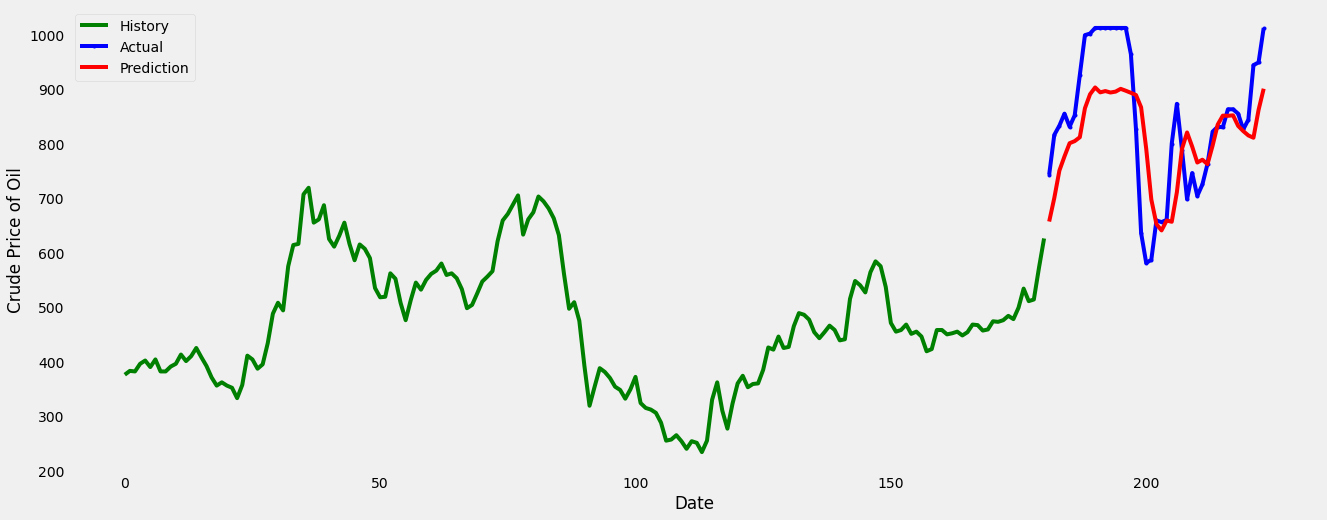

In [ ]:
plt.figure(figsize=(20,8))
plt.grid()
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_predRS_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Date')
plt.legend()
plt.show();

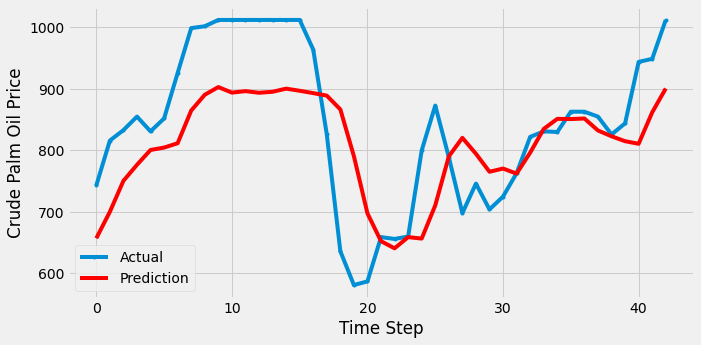

In [ ]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_predRS_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
MAE_cnn = mean_absolute_error(y_test_inv, y_predRS_inv)
print('MAE value of the CNN Model is:', MAE_cnn)

MDA_cnn = mda(y_test_inv, y_predRS_inv)
print('MDA value of the CNN Model is:', MDA_cnn)

MAPE_cnn = mean_absolute_percentage_error(y_test_inv, y_predRS_inv)
print('MAPE value of the CNN Model is:', MAPE_cnn)

RMSE_cnn = mean_squared_error(y_test_inv,y_predRS_inv, squared=False)
print('RMSE value of the CNN Model is:', RMSE_cnn)

MSE_cnn = mean_squared_error(y_test_inv,y_predRS_inv)
print('MSE value of the CNN Model is:', MSE_cnn)

EVS_cnn = explained_variance_score(y_test_inv, y_predRS_inv)
print('EVS score of the CNN Model is:', EVS_cnn)

MAE value of the CNN Model is: 78.12177223382994
MDA value of the CNN Model is: 0.5476190476190477
MAPE value of the CNN Model is: 9.43136011973361
RMSE value of the CNN Model is: 96.73654538788897
MSE value of the CNN Model is: 9357.959213583103
EVS score of the CNN Model is: 0.4951717832781205


###Applying Bayesian Optimization

In [ ]:
...updating